<a href="https://colab.research.google.com/github/MattJCR/Practica-DEEP-LEARNING/blob/master/Practica_DEEP_LEARNING_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
47/47 [==============================] - 143s 3s/step - loss: 1.6288 - accuracy: 0.7738 - val_loss: 0.9946 - val_accuracy: 0.8420
Epoch 2/10
47/47 [==============================] - 135s 3s/step - loss: 0.3315 - accuracy: 0.9352 - val_loss: 1.0557 - val_accuracy: 0.8623
Epoch 3/10
47/47 [==============================] - 136s 3s/step - loss: 0.1014 - accuracy: 0.9752 - val_loss: 1.0035 - val_accuracy: 0.8681
Epoch 4/10
47/47 [==============================] - 143s 3s/step - loss: 0.0982 - accuracy: 0.9765 - val_loss: 1.7705 - val_accuracy: 0.8188
Epoch 5/10
47/47 [==============================] - 140s 3s/step - loss: 0.1345 - accuracy: 0.9701 - val_loss: 1.6464 - val_accuracy: 0.8464
Epoch 6/10
47/47 [==============================] - 138s 3s/step - loss: 0.0991 - accuracy: 0.9765 - val_loss: 1.8034 - val_accuracy: 0.8507
Epoch 7/10
47/47 [==============================] - 137s 3s/step - loss: 0.1037 - accuracy: 0.9772 - val_loss: 2.0060 - val_accuracy: 0.8435
Epoch 8/10
47

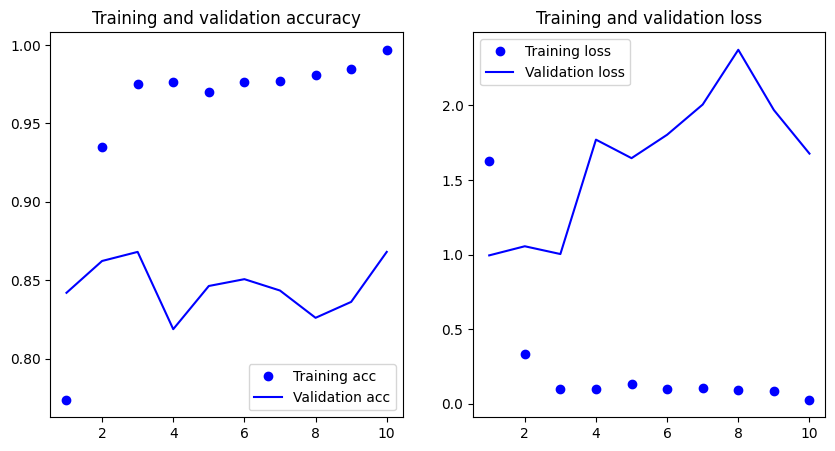

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Definir el tamaño de imagen de entrada y batch size
IMAGE_SIZE = [192, 192]
BATCH_SIZE = 64

# Cargar los datos del conjunto de entrenamiento y validación
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
VALIDATION_SPLIT = 0.19

filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)

training_filenames = filenames[split:]
validation_filenames = filenames[:split]

# Leer los archivos TFRecord
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset = load_dataset(training_filenames)
validation_dataset = load_dataset(validation_filenames)

# Definir el modelo
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_dataset, epochs=10,
                    validation_data=validation_dataset)

# Mostrar la curva de aprendizaje
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)